In [11]:
# 현재 최대 점수 !!! 0.5330428221
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTENC, SMOTEN
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss, InstanceHardnessThreshold, NeighbourhoodCleaningRule, OneSidedSelection, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from catboost import  CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingClassifier
import numpy as np

In [62]:
train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")

columns = ['f1_score', 'after0cnt', 'after1cnt']
df = pd.DataFrame(columns=columns)

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전처리 후 학습 데이터 확인
train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,0.167046,-0.121165,-0.015962,-0.829869,0.786885,1.038128,-0.669045,-0.024844,0.090246,1,0,1.400157,5,0
1,a0a60abb,0.621553,0.357181,1.152389,0.316456,0.498363,0.212579,2.261009,-0.594656,-0.702077,2,0,-0.711163,6,1
2,b9f171ae,1.530566,-1.675788,0.400155,-0.591616,0.065581,0.487762,1.939124,-0.024844,0.090246,2,1,-1.414937,7,1
3,5dc0ba8b,-1.650980,0.476767,0.877690,-0.218820,0.931145,1.588495,-0.489192,-1.734280,-0.702077,1,0,-0.711163,0,1
4,65c83654,-1.196473,-1.197443,2.130972,-0.431503,0.931145,-0.612970,0.691049,-0.594656,0.090246,2,0,0.696384,0,1


In [8]:
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train.value_counts()

target
1    4957
0    3043
Name: count, dtype: int64

In [63]:
under_sampling = [ClusterCentroids(random_state=42), EditedNearestNeighbours(), RepeatedEditedNearestNeighbours(), 
            AllKNN(sampling_strategy='auto'), NearMiss(), InstanceHardnessThreshold(random_state=42), NeighbourhoodCleaningRule(), 
            OneSidedSelection(random_state=42), TomekLinks()]
under_df = pd.DataFrame(columns=columns)
for sampler in under_sampling:
    
    # 특성과 타겟 변수 분리
    X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
    y = train['target']

    # 학습 데이터와 검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

    # 훈련 데이터를 기반으로 클래스 가중치 계산 
    class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train_sampled)
    weights = {i: w for i, w in enumerate(class_weight)}

    #cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
    #mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
    voting_model = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)

    # voting_model = VotingClassifier(estimators=
    #                             [('cat', cat),
    #                             ('mp', mp)],
    #                             #('xgb', xgb)],
    #                             voting='soft',
    #                             weights=[0.2, 0.8]

                                
    #                             )

    voting_model.fit(X_train_sampled, y_train_sampled)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
    clear_output(wait=True)
    print(f'max_val : {val_f1}')
    print(classification_report(y_val, val_predictions, zero_division=0))

    under_df.loc[sampler] = [val_f1, y_train_sampled.value_counts()[0], y_train_sampled.value_counts()[1]]
    print(under_df)
    # test.drop(columns=['user_id'], inplace=True, axis=1) 
    # test_predictions = voting_model.predict(test)

    # # 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
    # sample['target'] = test_predictions

    # # 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
    # submit_path = './voting(cat, mp)_drop(None)_nopreprocessing).csv'
    # sample.to_csv(submit_path, index=False)

    # sample.head()

max_val : 0.5018635917402952
              precision    recall  f1-score   support

           0       0.38      0.43      0.40       758
           1       0.62      0.58      0.60      1242

    accuracy                           0.52      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.52      0.53      2000

                                            f1_score  after0cnt  after1cnt
ClusterCentroids(random_state=42)           0.483967     3043.0     3043.0
EditedNearestNeighbours()                   0.453616     3043.0     1209.0
RepeatedEditedNearestNeighbours()           0.453616     3043.0     1209.0
AllKNN()                                    0.470172     3043.0     1473.0
NearMiss()                                  0.481545     3043.0     3043.0
InstanceHardnessThreshold(random_state=42)  0.516452     3043.0     3141.0
NeighbourhoodCleaningRule()                 0.488471     3043.0     2107.0
OneSidedSelection(random_state=42)          

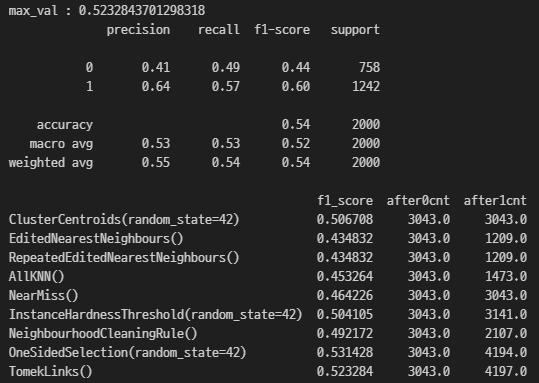

In [64]:
over_sampling = [SVMSMOTE(random_state=42), SMOTE(random_state=42), SMOTENC(random_state=42, categorical_features=[9, 10, 12]), 
                 SMOTEN(random_state=42), ADASYN(random_state=42),
            BorderlineSMOTE(random_state=42)]
over_df = pd.DataFrame(columns=columns)
for sampler in over_sampling:
    
    # 특성과 타겟 변수 분리
    X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
    y = train['target']

    # 학습 데이터와 검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

    # 훈련 데이터를 기반으로 클래스 가중치 계산 
    class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train_sampled)
    weights = {i: w for i, w in enumerate(class_weight)}

    #cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
    #mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
    voting_model = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)

    # voting_model = VotingClassifier(estimators=
    #                             [('cat', cat),
    #                             ('mp', mp)],
    #                             #('xgb', xgb)],
    #                             voting='soft',
    #                             weights=[0.2, 0.8]

                                
    #                             )

    voting_model.fit(X_train_sampled, y_train_sampled)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
    clear_output(wait=True)
    print(f'max_val : {val_f1}')
    print(classification_report(y_val, val_predictions, zero_division=0))

    over_df.loc[sampler] = [val_f1, y_train.value_counts()[0], y_train.value_counts()[1]]
    print(over_df)
    # test.drop(columns=['user_id'], inplace=True, axis=1) 
    # test_predictions = voting_model.predict(test)

    # # 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
    # sample['target'] = test_predictions

    # # 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
    # submit_path = './voting(cat, mp)_drop(None)_nopreprocessing).csv'
    # sample.to_csv(submit_path, index=False)

    # sample.head()

max_val : 0.4999737673603862
              precision    recall  f1-score   support

           0       0.38      0.36      0.37       758
           1       0.62      0.64      0.63      1242

    accuracy                           0.53      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.53      0.53      2000

                                                    f1_score  after0cnt  \
SVMSMOTE(random_state=42)                           0.503500     3043.0   
SMOTE(random_state=42)                              0.518754     3043.0   
SMOTENC(categorical_features=[9, 10, 12], rando...  0.488717     3043.0   
SMOTEN(random_state=42)                             0.517431     3043.0   
ADASYN(random_state=42)                             0.511133     3043.0   
BorderlineSMOTE(random_state=42)                    0.499974     3043.0   

                                                    after1cnt  
SVMSMOTE(random_state=42)                             

In [65]:
combine_sampling = [SMOTEENN(random_state=42), SMOTETomek(random_state=42)]
combine_df = pd.DataFrame(columns=columns)
for sampler in combine_sampling:
    
    # 특성과 타겟 변수 분리
    X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
    y = train['target']

    # 학습 데이터와 검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

    # 훈련 데이터를 기반으로 클래스 가중치 계산 
    class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train_sampled)
    weights = {i: w for i, w in enumerate(class_weight)}

    #cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
    #mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
    voting_model = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)

    # voting_model = VotingClassifier(estimators=
    #                             [('cat', cat),
    #                             ('mp', mp)],
    #                             #('xgb', xgb)],
    #                             voting='soft',
    #                             weights=[0.2, 0.8]

                                
    #                             )

    voting_model.fit(X_train_sampled, y_train_sampled)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
    clear_output(wait=True)
    print(f'max_val : {val_f1}')
    print(classification_report(y_val, val_predictions, zero_division=0))

    combine_df.loc[sampler] = [val_f1, y_train.value_counts()[0], y_train.value_counts()[1]]
    print(combine_df)
    # test.drop(columns=['user_id'], inplace=True, axis=1) 
    # test_predictions = voting_model.predict(test)

    # # 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
    # sample['target'] = test_predictions

    # # 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
    # submit_path = './voting(cat, mp)_drop(None)_nopreprocessing).csv'
    # sample.to_csv(submit_path, index=False)

    # sample.head()

max_val : 0.5079194703634633
              precision    recall  f1-score   support

           0       0.39      0.41      0.40       758
           1       0.63      0.61      0.62      1242

    accuracy                           0.53      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.54      0.53      0.53      2000

                             f1_score  after0cnt  after1cnt
SMOTEENN(random_state=42)    0.488222     3043.0     4957.0
SMOTETomek(random_state=42)  0.507919     3043.0     4957.0


In [66]:
from imblearn.pipeline import Pipeline
for over_sampler in over_sampling:
    for under_sampler in under_sampling:
        try:
            # 특성과 타겟 변수 분리
            X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
            y = train['target']

            # 학습 데이터와 검증 데이터 분리
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

            sampler = Pipeline([
                ('over', over_sampler),
                ('under', under_sampler)
            ])
            X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

            # 훈련 데이터를 기반으로 클래스 가중치 계산 
            class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train_sampled)
            weights = {i: w for i, w in enumerate(class_weight)}

            #cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
            #mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
            voting_model = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)

            # voting_model = VotingClassifier(estimators=
            #                             [('cat', cat),
            #                             ('mp', mp)],
            #                             #('xgb', xgb)],
            #                             voting='soft',
            #                             weights=[0.2, 0.8]

                                        
            #                             )
            voting_model.fit(X_train_sampled, y_train_sampled)

            # 검증 데이터에서 성능 평가
            val_predictions = voting_model.predict(X_val)
            val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
            #clear_output(wait=True)
            #print(f'max_val : {val_f1}')
            #print(classification_report(y_val, val_predictions, zero_division=0))

            combine_df.loc[str(over_sampler) + str(under_sampler)] = [val_f1, y_train.value_counts()[0], y_train.value_counts()[1]]
            #print(combine_df)
            # test.drop(columns=['user_id'], inplace=True, axis=1) 
            # test_predictions = voting_model.predict(test)

            # # 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
            # sample['target'] = test_predictions

            # # 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
            # submit_path = './voting(cat, mp)_drop(None)_nopreprocessing).csv'
            # sample.to_csv(submit_path, index=False)

            # sample.head()
        except:
            print(str(over_sampler) + str(under_sampler), 'fail')
            continue
print(combine_df)

c:\Users\dbswo\anaconda3\envs\subs_predict\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


SVMSMOTE(random_state=42)OneSidedSelection(random_state=42) fail


c:\Users\dbswo\anaconda3\envs\subs_predict\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


SMOTE(random_state=42)OneSidedSelection(random_state=42) fail


c:\Users\dbswo\anaconda3\envs\subs_predict\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


SMOTENC(categorical_features=[9, 10, 12], random_state=42)OneSidedSelection(random_state=42) fail


c:\Users\dbswo\anaconda3\envs\subs_predict\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


SMOTEN(random_state=42)OneSidedSelection(random_state=42) fail


c:\Users\dbswo\anaconda3\envs\subs_predict\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dbswo\anaconda3\envs\subs_predict\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                                    f1_score  after0cnt  \
SMOTEENN(random_state=42)                           0.488222     3043.0   
SMOTETomek(random_state=42)                         0.507919     3043.0   
SVMSMOTE(random_state=42)ClusterCentroids(rando...  0.518347     3043.0   
SVMSMOTE(random_state=42)EditedNearestNeighbours()  0.454084     3043.0   
SVMSMOTE(random_state=42)RepeatedEditedNearestN...  0.461992     3043.0   
SVMSMOTE(random_state=42)AllKNN()                   0.501986     3043.0   
SVMSMOTE(random_state=42)NearMiss()                 0.506867     3043.0   
SVMSMOTE(random_state=42)InstanceHardnessThresh...  0.507373     3043.0   
SVMSMOTE(random_state=42)NeighbourhoodCleaningR...  0.495838     3043.0   
SVMSMOTE(random_state=42)TomekLinks()               0.494001     3043.0   
SMOTE(random_state=42)ClusterCentroids(random_s...  0.511786     3043.0   
SMOTE(random_state=42)EditedNearestNeighbours()     0.430974     3043.0   
SMOTE(random_state=42)Rep

In [67]:
pd.concat([under_df, over_df, combine_df]).sort_values("f1_score", ascending=False)

,f1_score,after0cnt,after1cnt
BorderlineSMOTE(random_state=42)InstanceHardnessThreshold(random_state=42),0.525230,3043.0,4957.0
ADASYN(random_state=42)NearMiss(),0.522298,3043.0,4957.0
SMOTE(random_state=42),0.518754,3043.0,4957.0
SVMSMOTE(random_state=42)ClusterCentroids(random_state=42),0.518347,3043.0,4957.0
SMOTEN(random_state=42)NearMiss(),0.518339,3043.0,4957.0
...,...,...,...
BorderlineSMOTE(random_state=42)RepeatedEditedNearestNeighbours(),0.439288,3043.0,4957.0
"SMOTENC(categorical_features=[9, 10, 12], random_state=42)RepeatedEditedNearestNeighbours()",0.435178,3043.0,4957.0
"SMOTENC(categorical_features=[9, 10, 12], random_state=42)EditedNearestNeighbours()",0.433206,3043.0,4957.0
SMOTE(random_state=42)EditedNearestNeighbours(),0.430974,3043.0,4957.0


In [68]:
# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

sampler = Pipeline([
('over', BorderlineSMOTE(random_state=42)),
('under', InstanceHardnessThreshold(random_state=42))
])
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train_sampled)
weights = {i: w for i, w in enumerate(class_weight)}

#cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
#mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
voting_model = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)

# voting_model = VotingClassifier(estimators=
#                             [('cat', cat),
#                             ('mp', mp)],
#                             #('xgb', xgb)],
#                             voting='soft',
#                             weights=[0.2, 0.8]

                        
#                             )
voting_model.fit(X_train_sampled, y_train_sampled)

# 검증 데이터에서 성능 평가
val_predictions = voting_model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
#clear_output(wait=True)
print(f'max_val : {val_f1}')
print(classification_report(y_val, val_predictions, zero_division=0))

max_val : 0.525229533664062
              precision    recall  f1-score   support

           0       0.41      0.43      0.42       758
           1       0.64      0.62      0.63      1242

    accuracy                           0.55      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.55      0.55      0.55      2000



## 최종

In [59]:
# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sampled, y_train_sampled = TomekLinks().fit_resample(X_train, y_train)

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train_sampled)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)

voting_model = VotingClassifier(estimators=
                            [('cat', cat),
                            ('mp', mp)],
                            #('xgb', xgb)],
                            voting='soft',
                            weights=[0.2, 0.8]

                            
                            )

voting_model.fit(X_train_sampled, y_train_sampled)

# 검증 데이터에서 성능 평가
val_predictions = voting_model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
clear_output(wait=True)
print(f'max_val : {val_f1}')
print(classification_report(y_val, val_predictions, zero_division=0))

max_val : 0.5232843701298318
              precision    recall  f1-score   support

           0       0.41      0.49      0.44       758
           1       0.64      0.57      0.60      1242

    accuracy                           0.54      2000
   macro avg       0.53      0.53      0.52      2000
weighted avg       0.55      0.54      0.54      2000



In [61]:
#test.drop(columns=['user_id'], inplace=True, axis=1) 
test_predictions = voting_model.predict(test)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions

# 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
submit_path = './voting_model/voting(cat, mp)_drop(None)_nopreprocessing_tomeks.csv'
sample.to_csv(submit_path, index=False)

sample.head()

,user_id,target
0,0001d6e9,1
1,0002c77d,0
2,0002df5b,0
3,000b6068,1
4,00184a0c,1
